In [514]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import seaborn as sns
from tqdm import tqdm

PALLETE = [[0, 0, 0],[0, 0, 255]]

In [498]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min) / ((band_max - band_min)))

def standardize(band):
    band_mean, band_std = (band.mean(), band.std())
    if band_std == 0:
        return np.zeros(band.shape)
    return (band - band_mean) / band_std

In [307]:
def brighten(band):
    alpha = 0.13
    beta = 0
    return np.clip(alpha * band + beta, 0, 255)

In [308]:
def convert(im_path):
    with rasterio.open(im_path) as fin:
        red = fin.read(3)
        green = fin.read(2)
        blue = fin.read(1)

    red_b = brighten(red)
    blue_b = brighten(blue)
    green_b = brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    return np.dstack((blue_b, green_b, red_b)), np.dstack((red_bn, green_bn, blue_bn))

In [311]:
def plot_data(image_path, mask_path):
    plt.figure(figsize=(12, 12))
    pal = [value for color in PALLETE for value in color]

    plt.subplot(1, 2, 1)
    _, img = convert(image_path)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    with rasterio.open(mask_path) as fin:
        mask = fin.read(1)
    mask = Image.fromarray(mask).convert('P')
    mask.putpalette(pal)
    plt.imshow(mask)
    plt.show()
    
img_6_1_path = 'dataset/train/images/6_1.tif'
img_6_1_mask_path = 'dataset/train/masks/6_1.tif'
img_6_2_path = 'dataset/train/images/6_2.tif'
img_6_2_mask_path = 'dataset/train/masks/6_2.tif'

img_9_1_path = 'dataset/train/images/9_1.tif'
img_9_1_mask_path = 'dataset/train/masks/9_1.tif'
img_9_2_path = 'dataset/train/images/9_2.tif'
img_9_2_mask_path = 'dataset/train/masks/9_2.tif'

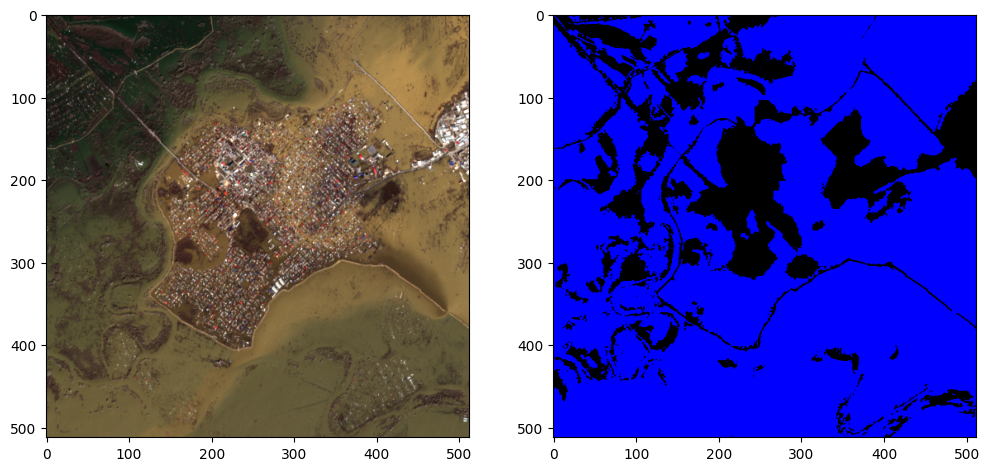

In [312]:
plot_data(img_9_2_path, img_9_2_mask_path)

## Внешние данные 

Так как у нас есть координаты снимков, то возникает идея подгрузить, напрмер, данные о высоте или и водоемах с карт. Попробуем это сделать

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.8f21832fe23d4edd82b046e069ab1279.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 58.526573 51.224787 58.60128808159393 51.17980244186047 SRTM1.8f21832fe23d4edd82b046e069ab1279.vrt /tmp/.elevation651.tif
rm -f SRTM1.8f21832fe23d4edd82b046e069ab1279.vrt


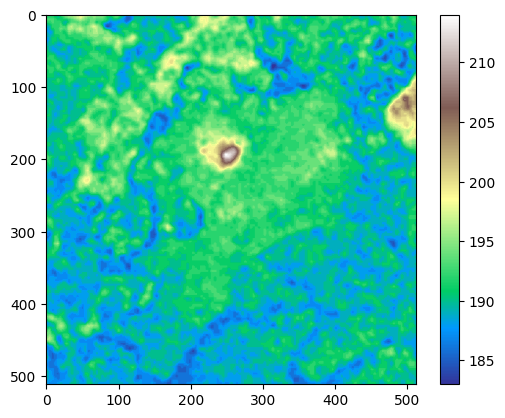

In [316]:
from baseline.models.load_elevations import load_and_add_elevation_data

img_with_elevation = load_and_add_elevation_data(img_9_2_path)
plt.imshow(img_with_elevation[-1], cmap='terrain')
plt.colorbar()
plt.show()

Совместим со снимком и маской для понимания ситуации

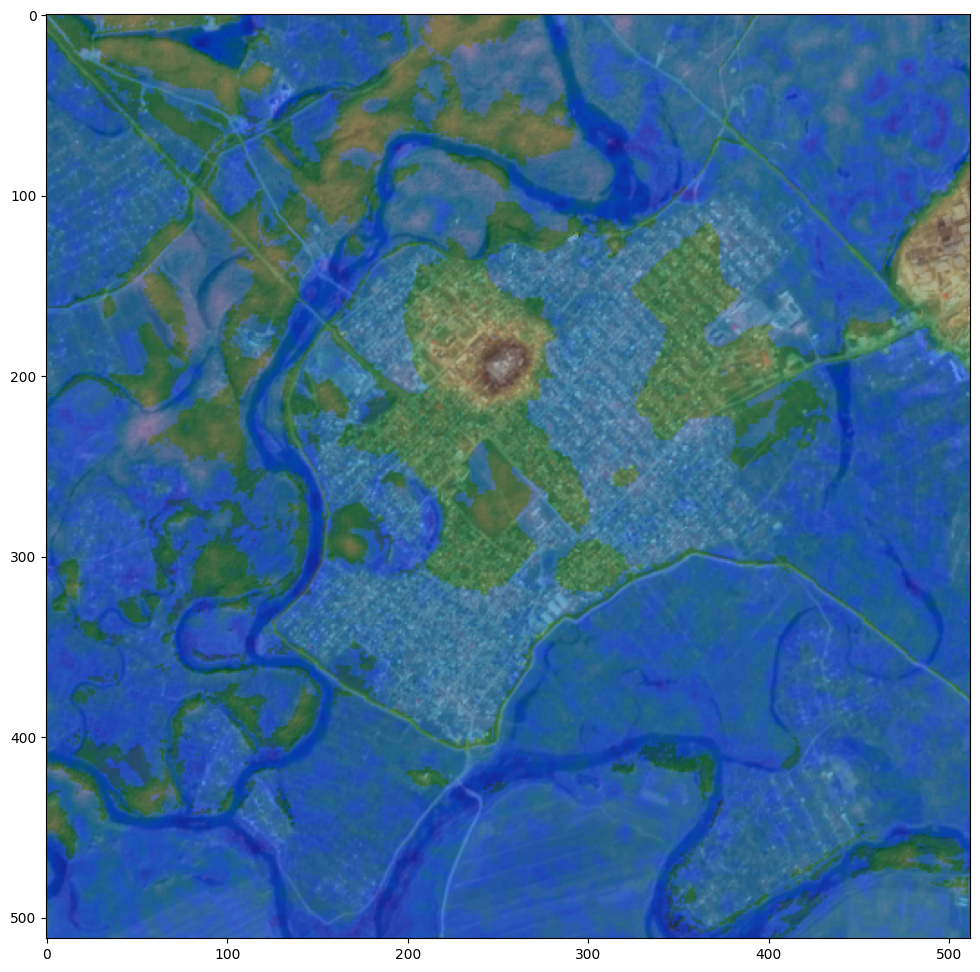

In [324]:
mask = rasterio.open(img_9_2_mask_path).read(1)
mask = Image.fromarray(mask).convert('P')
mask.putpalette([0, 0, 0, 0, 0, 255])

img = convert(img_9_1_path)[1]
elevation = img_with_elevation[-1]

plt.figure(figsize=(12, 12))
plt.imshow(elevation, cmap='terrain')
plt.imshow(img, alpha=0.5)
plt.imshow(mask, alpha=0.3)

plt.show()

Как и следовало ожидать, самые высокие части не затопило - это может помочь модели с предсказанием. Однако с другой стороны данные о высоте не очень точные и логика затопления довольно сложная

Попробуем еще одну идею - подгружать данные о водоемах с OSM

/var/folders/94/nzsdn_8d0xq75jf__rhww7hr0000gn/T/ipykernel_95030/2350065246.py:7: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  water_bodies = ox.geometries_from_bbox(north, south, east, west, tags)
/Users/flypew/hackathons/Skoltech_Floods/.venv/lib/python3.12/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
/Users/flypew/hackathons/Skoltech_Floods/.venv/lib/python3.12/site-packages/osmnx/geomet

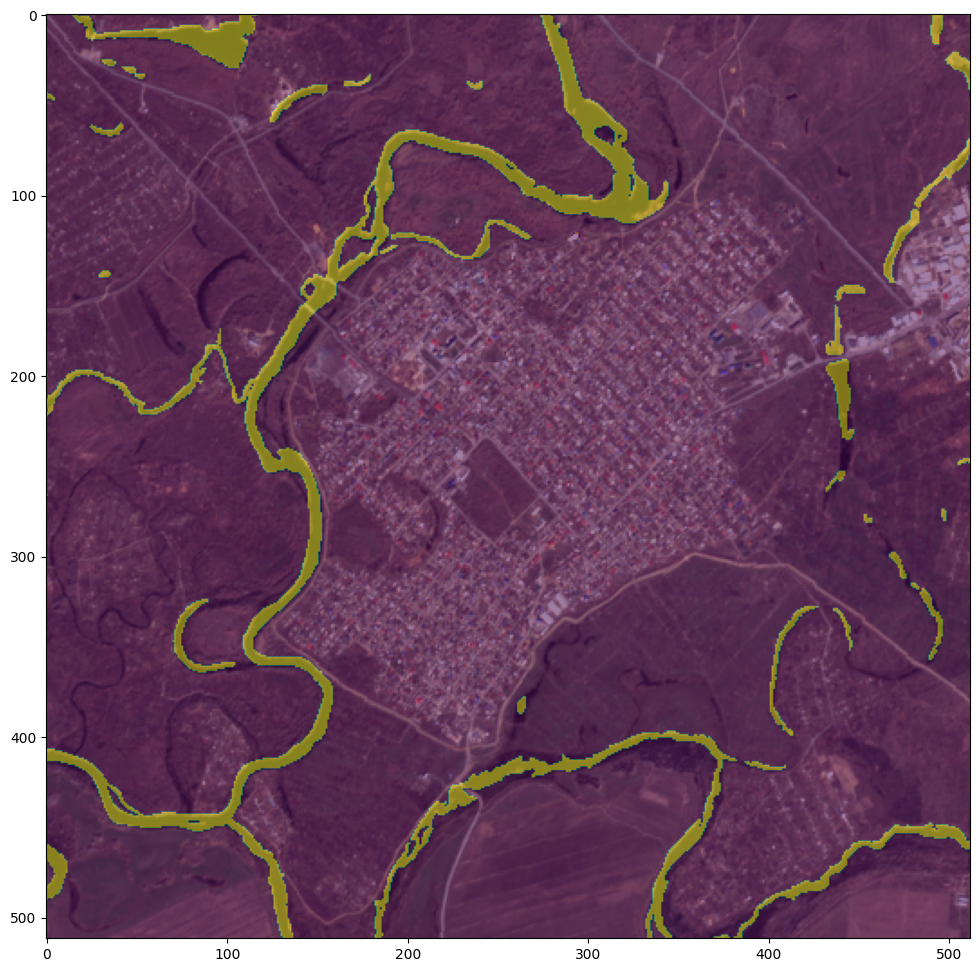

In [329]:
import osmnx as ox
import geopandas as gpd
from rasterio.features import rasterize

def get_water_bodies_osm(north, south, east, west):
    tags = {'natural': ['water'], 'water': True}
    water_bodies = ox.geometries_from_bbox(north, south, east, west, tags)
    return water_bodies

borders = rasterio.open(img_9_1_path).bounds
water = get_water_bodies_osm(north=borders.top, south=borders.bottom, east=borders.right, west=borders.left)
img_tif = rasterio.open(img_9_1_path)

water_mask = rasterize(
    [(geom, 1) for geom in water.geometry],
    out_shape=(img_tif.height, img_tif.width),
    transform=img_tif.transform,
    all_touched=True,
    fill=0,
    default_value=1
)

plt.figure(figsize=(12, 12))
plt.imshow(water_mask)
plt.imshow(img, alpha=0.5)

Разметка совсем не полная, но может помочь модели понять где была вода до затопления в сложных случаях

Можно попробовать еще такое использование высот: симулировать перетекание воды с высоких мест на низкие и тем самым улучшить предсказания

In [491]:
from collections import deque

def flow_water(water_mask: np.ndarray, elevation: np.ndarray) -> np.ndarray:
    """
    If water is located in (x, y), (a, b) is a neighbour pixel, and elevation[x, y] > elevation[a, b],
    then water can flow from (x, y) to (a, b). Continue this process and return a new mask
    """
    
    queue = deque()
    queue.extend(np.argwhere(water_mask == 1))
    
    water_mask = water_mask.copy()
    
    while queue:
        x, y = queue.popleft()
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < water_mask.shape[0] and 0 <= ny < water_mask.shape[1]:
                if water_mask[nx, ny] == 0 and elevation[x, y] > elevation[nx, ny]:
                    water_mask[nx, ny] = 1
                    queue.append((nx, ny))
                    
    return water_mask

mask = rasterio.open(img_9_2_mask_path).read(1)
new_water_mask = flow_water(mask, img_with_elevation[-1])

np.sum(new_water_mask - mask)

np.uint64(1841)

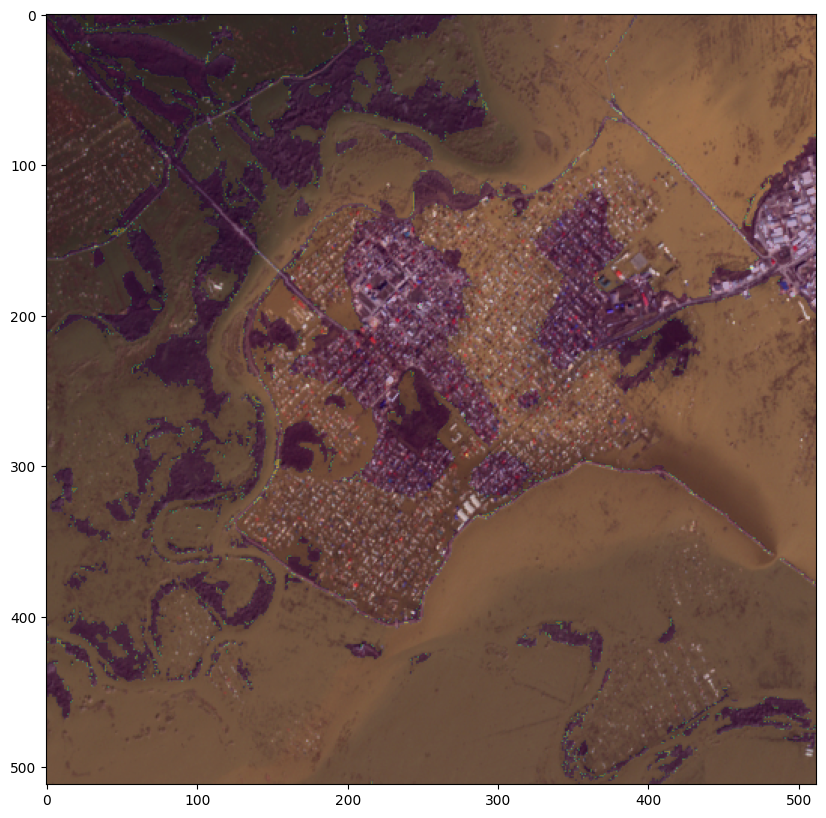

In [492]:
plt.figure(figsize=(10, 10))
plt.imshow(convert(img_9_2_path)[1])
plt.imshow(new_water_mask - mask, alpha=0.3)
plt.imshow(mask, alpha=0.1)
plt.show()

Видим что к макске затопления прибавляется не так много пикселей, поэтому идея имеет право на жизнь

## Распределение значений каналов

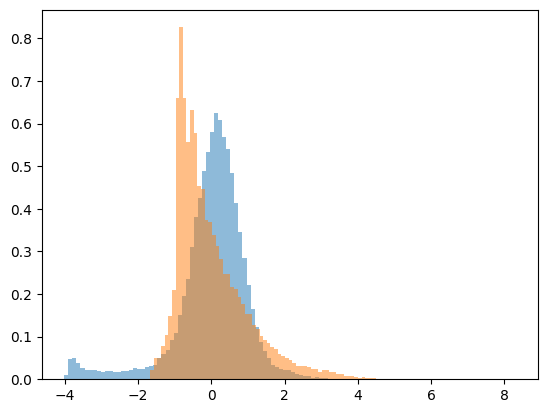

In [513]:
ch = 5
img1 = rasterio.open(img_9_1_path).read()
img2 = rasterio.open(img_9_2_path).read()

channel = img1[ch].flatten()
clipped = np.clip(channel, *np.quantile(channel, [0.0001, 0.9999]))
arr = standardize(clipped)
plt.hist(arr, bins=100, alpha=0.5, label='img1', density=True)

channel = img2[ch].flatten()
clipped = np.clip(channel, *np.quantile(channel, [0.0001, 0.9999]))
arr = standardize(clipped)
plt.hist(arr, bins=100, alpha=0.5, label='img2', density=True)
plt.show()

Несколько наблюдений:
- Распределения с тяжелыми хвостами, есть выбросы - поэтому надо аккуратно обрабатывать данные
- После затопления распределение перестало быть похожим на нормальное

In [520]:
img1 = rasterio.open(img_9_2_path).read()
img1_before = rasterio.open(img_9_1_path).read()
img2 = rasterio.open(img_6_2_path).read()
img2_before = rasterio.open(img_6_1_path).read()
mask1 = rasterio.open(img_9_2_mask_path).read(1)
mask1_before = rasterio.open(img_9_1_mask_path).read(1)
mask2 = rasterio.open(img_6_2_mask_path).read(1)
mask2_before = rasterio.open(img_6_1_mask_path).read(1)

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


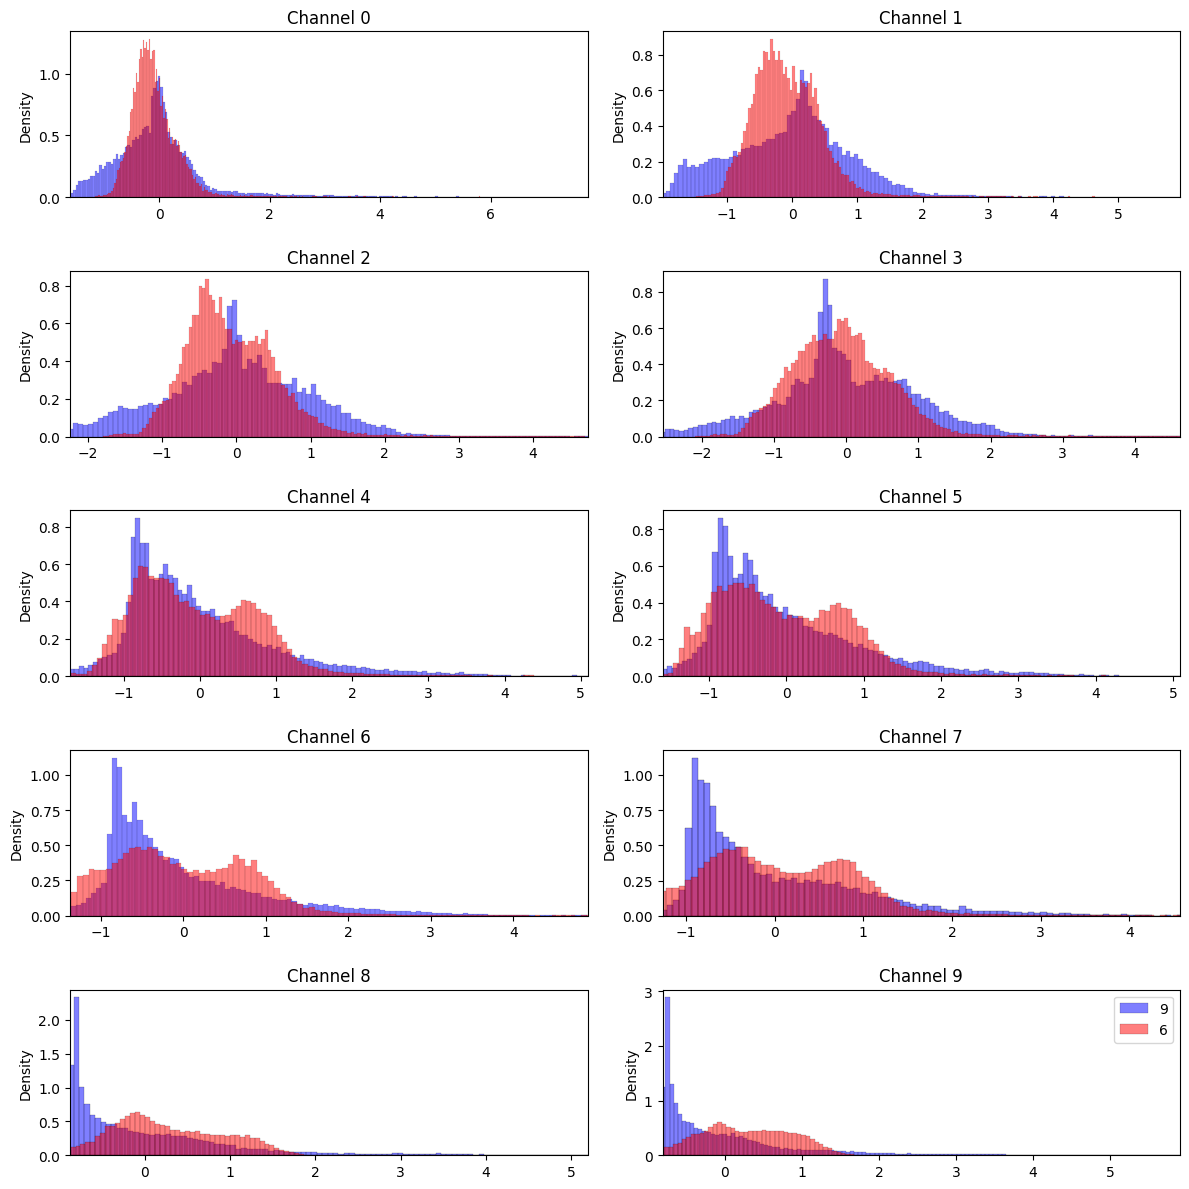

In [533]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12))

for i in tqdm(range(10)):
    ch1 = img1[i].flatten()
    ch2 = img2[i].flatten()
    
    def standardize(x):
        return (x - np.mean(x)) / np.std(x)
    
    ch1 = standardize(ch1)
    ch2 = standardize(ch2)
    
    ch1 = np.random.choice(ch1, 50000)
    ch2 = np.random.choice(ch2, 50000)
    
    sns.histplot(ch1, color='blue', alpha=0.5, kde=False, stat='density', ax=ax[i // 2, i % 2])
    sns.histplot(ch2, color='red', alpha=0.5, kde=False, stat='density', ax=ax[i // 2, i % 2])
    plt.legend(['9', '6'])
    
    leftq = np.percentile(ch1, 0.1)
    rightq = np.percentile(ch1, 99.9)
    ax[i // 2, i % 2].set_xlim(leftq, rightq)
    ax[i // 2, i % 2].set_title(f'Channel {i}')
    
plt.tight_layout(h_pad=2)
plt.show()

Вот тут проблема. Рапсределеняи значений каналов на разных изображениях не похожи даже после скейлинга. Это проблема, так как обобщающей способности модели скорее всего не хватит чтобы с этим справиться. Действительно, мы пытались обучить модель только на одной картинке и тогда на другой она выдавала совершенно неправильные результаты. Немного ситуацию исправляет передача в модели данных OSM - это дает некий референс воды

Что делать? Давайте посмотрим на дельту до и после затопления!

In [528]:
d_img1 = img1.astype(np.float32) - img1_before.astype(np.float32)
d_img2 = img2.astype(np.float32) - img2_before.astype(np.float32)

100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


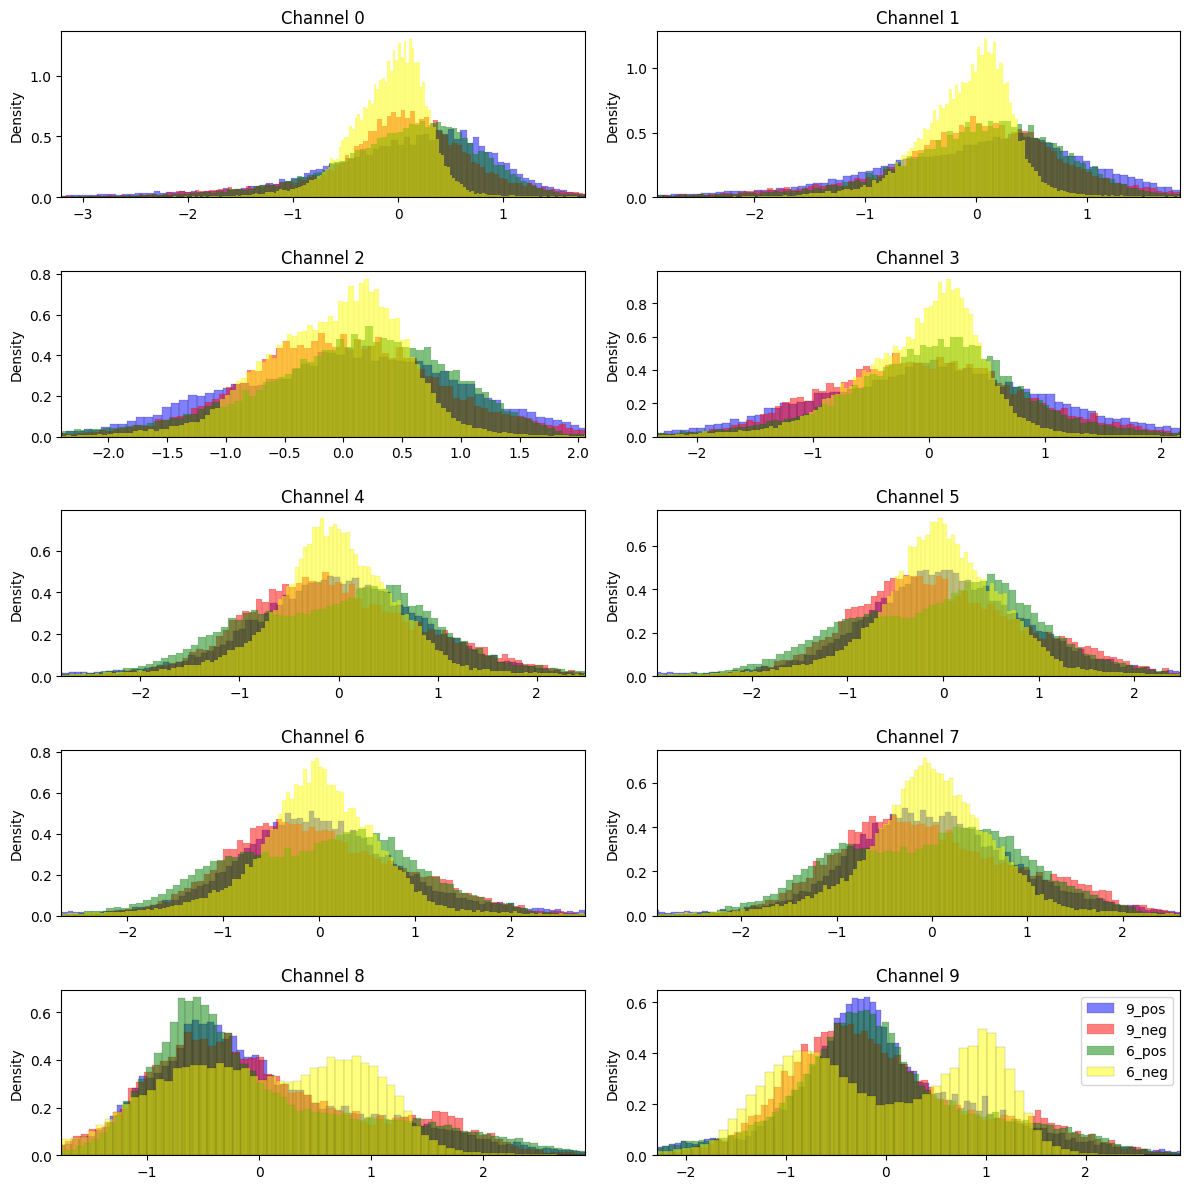

In [531]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12))

for i in tqdm(range(10)):
    ch1_pos = d_img1[i, :, :][(mask1 == 1) & (mask1_before == 0)].flatten()
    ch1_neg = d_img1[i, :, :][mask1 == 0].flatten()
    ch2_pos = d_img2[i, :, :][(mask2 == 1) & (mask2_before == 0)].flatten()
    ch2_neg = d_img2[i, :, :][mask2 == 0].flatten()
    
    def standardize(x):
        return (x - np.mean(x)) / np.std(x)
    
    ch1_pos = standardize(ch1_pos)
    ch1_neg = standardize(ch1_neg)
    ch2_pos = standardize(ch2_pos)
    ch2_neg = standardize(ch2_neg)
    
    ch1_pos = np.random.choice(ch1_pos, 50000)
    ch1_neg = np.random.choice(ch1_neg, 50000)
    ch2_pos = np.random.choice(ch2_pos, 50000)
    ch2_neg = np.random.choice(ch2_neg, 50000)
    
    sns.histplot(ch1_pos, color='blue', alpha=0.5, kde=False, stat='density', ax=ax[i // 2, i % 2])
    sns.histplot(ch1_neg, color='red', alpha=0.5, kde=False, stat='density', ax=ax[i // 2, i % 2])
    sns.histplot(ch2_pos, color='green', alpha=0.5, kde=False, stat='density', ax=ax[i // 2, i % 2])
    sns.histplot(ch2_neg, color='yellow', alpha=0.5, kde=False, stat='density', ax=ax[i // 2, i % 2])
    plt.legend(['9_pos', '9_neg', '6_pos', '6_neg'])
    
    leftq = np.percentile(ch1_pos, 1)
    rightq = np.percentile(ch1_pos, 99)
    ax[i // 2, i % 2].set_xlim(leftq, rightq)
    ax[i // 2, i % 2].set_title(f'Channel {i}')
    
plt.tight_layout(h_pad=2)
plt.show()

Видно что распределения стали гораздо более похожими (и похожими в частности на нормальное распределение). Модели будет так сильно легче учиться. Поэтому идея такая: будем подавать в модель разность двух изображений и состояние воды до наводнения и предсказывать состояние после. К сожалению нам не хватило данных (у нас всего 2 картинки, а такие специфические данные в интернете найти не просто) и времени дял реализации этого.

Интересно что за желтое бимодальное распределение в 9 канале?

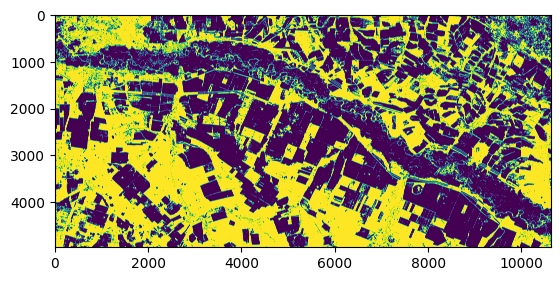

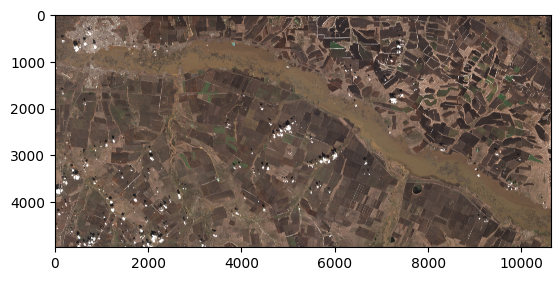

In [537]:
mask_new = np.zeros_like(mask2)
mask_new[standardize(d_img2[9]) > 0] = 1

plt.imshow(mask_new)
plt.show()
plt.imshow(convert(img_6_2_path)[1])
plt.show()

Неожиданно, но мы сегментировали поля. Видимо это связано с тем что вспаханные поля в конкртеном диапазоне при увлажнении изменяются по особенному. 

Это подтверждает что такая идея могла отлично сработать и для детекции затопленных участков